# Xây dựng lại mô hình GaitSet bằng TensorFlow

# Tải tập dữ liệu CASIA-B từ Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d duongkhang2810qs/casia-b-for-gaitset --unzip -p /content/CASIA-B

Dataset URL: https://www.kaggle.com/datasets/duongkhang2810qs/casia-b-for-gaitset
License(s): CC0-1.0
 99% 749M/758M [00:04<00:00, 248MB/s]
100% 758M/758M [00:05<00:00, 158MB/s]


## Khai báo thư viện

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import random
from collections import defaultdict
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import plot_model
from datetime import datetime

## Tạo tập huấn luyện và tập kiểm tra

In [ ]:
IMG_SIZE = 64
MAX_FRAMES = 30
HIDDEN_DIM = 256
DATA_PATH = '/content/CASIA-B'

In [ ]:
def load_sequence(path):
    frames = sorted(os.listdir(path))
    imgs = []
    for f in frames[:MAX_FRAMES]:
        img = cv2.imread(os.path.join(path, f), cv2.IMREAD_GRAYSCALE)
        # img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img[:, 10:-10]
        imgs.append(img / 255.0)
    while len(imgs) < MAX_FRAMES:
        imgs.append(np.zeros((IMG_SIZE, IMG_SIZE - 20)))
    return np.stack(imgs, axis=0).astype(np.float32)

In [ ]:
def get_subject_dict(subject_ids):
    subject_dict = {}
    for subject in sorted(os.listdir(DATA_PATH)):
        if subject not in subject_ids:
            continue
        subject_path = os.path.join(DATA_PATH, subject)
        all_paths = []
        for seq_type in os.listdir(subject_path):
            for view in os.listdir(os.path.join(subject_path, seq_type)):
                all_paths.append(os.path.join(subject_path, seq_type, view))
        if len(all_paths) >= 16:
            subject_dict[subject] = all_paths
    return subject_dict

In [ ]:
def gait_generator(subject_ids):
    subject_dict = get_subject_dict(subject_ids)
    subject_ids = list(subject_dict.keys())

    while True:
        sampled_ids = random.sample(subject_ids, 4)
        x_batch, y_batch, seq_types, views = [], [], [], []

        for sid in sampled_ids:
            grouped = defaultdict(list)
            for path in subject_dict[sid]:
                parts = path.split(os.sep)
                seq_type, view = parts[-2], parts[-1]
                grouped[(seq_type, view)].append(path)

            chosen = []
            for key in grouped:
                chosen.extend(random.sample(grouped[key], 1))
                if len(chosen) >= 16:
                    break
            if len(chosen) < 16:
                chosen.extend(random.sample(subject_dict[sid], 16 - len(chosen)))

            for path in chosen:
                x_batch.append(load_sequence(path))
                y_batch.append(int(sid))
                seq_types.append(path.split(os.sep)[-2])
                views.append(path.split(os.sep)[-1])

        if len(x_batch) < 64:
            continue

        yield np.stack(x_batch), np.array(y_batch), np.array(seq_types), np.array(views)

In [ ]:
def get_train_dataset(subject_ids):
    output_types = (tf.float32, tf.int32, tf.string, tf.string)
    output_shapes = ((64, MAX_FRAMES, IMG_SIZE, IMG_SIZE - 20), (64,), (64,), (64,))
    return tf.data.Dataset.from_generator(
        lambda: gait_generator(subject_ids), output_types, output_shapes
    ).prefetch(tf.data.AUTOTUNE)

In [ ]:
def get_test_dataset(subject_ids):
    data, labels, views, seq_types = [], [], [], []
    subject_dict = get_subject_dict(subject_ids)

    for sid in subject_ids:
        for path in subject_dict[sid]:
            parts = path.split(os.sep)
            seq_type, view = parts[-2], parts[-1]

            data.append(load_sequence(path))
            labels.append(int(sid))
            views.append(view)
            seq_types.append(seq_type)

    x = np.stack(data)
    y = np.array(labels)
    views = np.array(views)
    seq_types = np.array(seq_types)

    return tf.data.Dataset.from_tensor_slices((x, y, views, seq_types)).batch(64)

In [ ]:
all_ids = [f"{i:03d}" for i in range(1, 124 + 1) if i != 5]
train_ids = all_ids[:73]
test_ids = [i for i in all_ids if i not in train_ids]

train_ds = get_train_dataset(train_ids)
test_ds = get_test_dataset(test_ids)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


## Xây dựng lại mô hình GaitSet

In [ ]:
def basic_conv_block(out_channels, kernel_size, name):
    return tf.keras.Sequential([
        layers.Conv2D(out_channels, kernel_size, padding='same', use_bias=False, name=name + "_conv"),
        layers.LeakyReLU(name=name + "_act")
    ], name=name)

In [ ]:
def horizontal_pooling(gl, x, bin_num, fc_bin):
    gl = tf.transpose(gl, [0, 3, 1, 2])
    x = tf.transpose(x, [0, 3, 1, 2])
    n = tf.shape(gl)[0]
    feats = []

    for b in bin_num:
        g_split = tf.reshape(gl, [n, 128, b, -1])
        g_feat = tf.reduce_mean(g_split, -1) + tf.reduce_max(g_split, -1)

        x_split = tf.reshape(x, [n, 128, b, -1])
        x_feat = tf.reduce_mean(x_split, -1) + tf.reduce_max(x_split, -1)

        feats.extend([g_feat, x_feat])

    feat = tf.concat(feats, axis=2)
    feat = tf.transpose(feat, [2, 0, 1])
    feat = tf.einsum("tnc,tcd->tnd", feat, fc_bin)
    return tf.transpose(feat, [1, 0, 2])

In [ ]:
def build_gaitset(input_shape=(30, 64, 44), hidden_dim=256):
    inp = Input(shape=input_shape, name="input")
    x = layers.Reshape((30, 64, 44, 1))(inp)

    x = layers.TimeDistributed(basic_conv_block(32, 5, "set1"))(x)
    x = layers.TimeDistributed(basic_conv_block(32, 3, "set2"))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D(2))(x)

    gl = layers.Lambda(lambda x: tf.reduce_max(x, axis=1), name="frame_max_gl")(x)
    gl = basic_conv_block(64, 3, "gl1")(gl)
    gl = basic_conv_block(64, 3, "gl2")(gl)
    gl = layers.MaxPooling2D(2)(gl)

    x = layers.TimeDistributed(basic_conv_block(64, 3, "set3"))(x)
    x = layers.TimeDistributed(basic_conv_block(64, 3, "set4"))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D(2))(x)

    gl2 = layers.Lambda(lambda x: tf.reduce_max(x, axis=1), name="frame_max_gl2")(x)
    gl = basic_conv_block(128, 3, "gl3")(layers.Add()([gl, gl2]))
    gl = basic_conv_block(128, 3, "gl4")(gl)

    x = layers.TimeDistributed(basic_conv_block(128, 3, "set5"))(x)
    x = layers.TimeDistributed(basic_conv_block(128, 3, "set6"))(x)

    x_final = layers.Lambda(lambda x: tf.reduce_max(x, axis=1), name="frame_max_final")(x)
    gl = layers.Add()([gl, x_final])

    total_bins = sum([1, 2, 4, 8, 16]) * 2
    fc_bin = tf.Variable(
        tf.keras.initializers.glorot_uniform()((total_bins, 128, hidden_dim)),
        trainable=True, name="fc_bin"
    )
    out = layers.Lambda(lambda args: horizontal_pooling(*args, [1, 2, 4, 8, 16], fc_bin))([gl, x_final])

    return Model(inputs=inp, outputs=out, name="GaitSet")

In [ ]:
def triplet_loss(embeddings, labels, margin=0.2):
    if len(embeddings.shape) == 3:
        embeddings = tf.reduce_mean(embeddings, axis=1)

    labels = tf.reshape(labels, [-1])
    B = tf.shape(embeddings)[0]

    dist = tf.norm(tf.expand_dims(embeddings, 1) - tf.expand_dims(embeddings, 0), axis=2)

    pos_mask = tf.cast(tf.equal(tf.expand_dims(labels, 1), tf.expand_dims(labels, 0)), tf.float32)
    neg_mask = 1.0 - pos_mask
    pos_mask -= tf.eye(B)

    hard_pos = tf.reduce_max(dist * pos_mask, axis=1)
    masked_neg = dist + 1e5 * pos_mask
    hard_neg = tf.reduce_min(masked_neg, axis=1)
    hard_loss = tf.maximum(0.0, margin + hard_pos - hard_neg)

    dist_ap = tf.expand_dims(dist, 2)
    dist_an = tf.expand_dims(dist, 1)
    triplet = tf.maximum(0.0, margin + dist_ap - dist_an)

    mask_ap = tf.expand_dims(pos_mask, 2)
    mask_an = tf.expand_dims(neg_mask, 1)
    full_mask = mask_ap * mask_an

    full_loss = tf.reduce_sum(triplet * full_mask, axis=[1, 2])
    valid_count = tf.reduce_sum(full_mask, axis=[1, 2])
    full_loss = tf.where(valid_count > 0, full_loss / (valid_count + 1e-8), tf.zeros_like(full_loss))

    mean_dist = tf.reduce_mean(dist)
    return tf.reduce_mean(full_loss), tf.reduce_mean(hard_loss), mean_dist, tf.reduce_sum(full_mask)

In [ ]:
model = build_gaitset()
model.summary()
model.load_weights('model_inter2000.weights.h5')

Model: "GaitSet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 30, 64,    │          0 │ -                 │
│                     │ 44)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 30, 64,    │          0 │ input[0][0]       │
│                     │ 44, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 64,    │        800 │ reshape[0][0]     │
│ (TimeDistributed)   │ 44, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 30, 64,    │      9,216 │ time_distributed… │
│ (TimeDistributed)   │ 44, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 30, 32,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 22, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frame_max_gl        │ (None, 32, 22,    │          0 │ time_distributed… │
│ (Lambda)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 30, 32,    │     18,432 │ time_distributed… │
│ (TimeDistributed)   │ 22, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gl1 (Sequential)    │ (None, 32, 22,    │     18,432 │ frame_max_gl[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 30, 32,    │     36,864 │ time_distributed… │
│ (TimeDistributed)   │ 22, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gl2 (Sequential)    │ (None, 32, 22,    │     36,864 │ gl1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 30, 16,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 11, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 11,    │          0 │ gl2[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frame_max_gl2       │ (None, 16, 11,    │          0 │ time_distributed… │
│ (Lambda)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 11,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ frame_max_gl2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 30, 16,    │     73,728 │ time_distributed… │
│ (TimeDistributed)   │ 11, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gl3 (Sequential)    │ (None, 16, 11,    │     73,728 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 30, 16,    │    147,456 │ time_distributed

 Total params: 562,976 (2.15 MB)

 Trainable params: 562,976 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model.build(input_shape=(None, 30, 64, 44))
# model.load_weights('model_inter2000.weights.h5')

## Huấn luyện mô hình

In [ ]:
global_inter = 2000
optimizer = tf.keras.optimizers.Adam(1e-4)

for inter, (x_batch, y_batch, _, _) in enumerate(train_ds):
    with tf.GradientTape() as tape:
        embeddings = model(x_batch, training=True)
        full_loss, hard_loss, mean_dist, valid_count = triplet_loss(embeddings, y_batch)

    grads = tape.gradient(full_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    global_inter += 1

    if global_inter % 10 == 0:
        print(f"[Inter {global_inter:05d}] "
              f"full_loss={full_loss.numpy():.8f} | "
              f"hard_loss={hard_loss.numpy():.8f} | "
              f"mean_dist={mean_dist.numpy():.8f} | "
              f"valid_triplets={int(tf.reduce_sum(valid_count))}")

    if global_inter % 1000 == 0:
        model.save_weights(f'model_inter{global_inter}.weights.h5')
        print(f"Saved model at {global_inter} inter")
        break

[Inter 02010] full_loss=0.05691756 | hard_loss=1.89592505 | mean_dist=1.66414750 | valid_triplets=46080
[Inter 02020] full_loss=0.05341903 | hard_loss=1.63722157 | mean_dist=1.40363348 | valid_triplets=46080
[Inter 02030] full_loss=0.07183902 | hard_loss=1.65241528 | mean_dist=1.38246822 | valid_triplets=46080
[Inter 02040] full_loss=0.04632504 | hard_loss=1.61360431 | mean_dist=1.58958554 | valid_triplets=46080
[Inter 02050] full_loss=0.04932482 | hard_loss=1.67277932 | mean_dist=1.55590844 | valid_triplets=46080
[Inter 02060] full_loss=0.04510900 | hard_loss=1.42251909 | mean_dist=1.45239520 | valid_triplets=46080
[Inter 02070] full_loss=0.04855335 | hard_loss=1.43604493 | mean_dist=1.20421517 | valid_triplets=46080
[Inter 02080] full_loss=0.06092512 | hard_loss=1.39045250 | mean_dist=1.32874620 | valid_triplets=46080
[Inter 02090] full_loss=0.02506947 | hard_loss=1.29977107 | mean_dist=1.22965693 | valid_triplets=46080
[Inter 02100] full_loss=0.05244642 | hard_loss=1.37791717 | mean

## Đánh giá mô hình

In [ ]:
def extract_features(model, dataset):
    features, views, seq_types, labels = [], [], [], []
    for x_batch, y_batch, view_batch, seq_batch  in dataset:
        embeddings = model(x_batch, training=False)
        embeddings = tf.reduce_mean(embeddings, axis=1).numpy()
        features.append(embeddings)
        labels.extend(y_batch.numpy())
        seq_types.extend([s.decode() for s in seq_batch.numpy()])
        views.extend([v.decode() for v in view_batch.numpy()])
    return np.vstack(features), views, seq_types, labels

In [ ]:
def cosine_dist(x, y):
    x_norm = x / np.linalg.norm(x, axis=1, keepdims=True)
    y_norm = y / np.linalg.norm(y, axis=1, keepdims=True)
    return 1.0 - np.dot(x_norm, y_norm.T)

In [ ]:
def evaluation(features, views, seq_types, labels):
    views = np.array(views).astype(str)
    seq_types = np.array(seq_types).astype(str)
    labels = np.array(labels)

    view_list = sorted(set(views))
    view_num = len(view_list)

    probe_seq_dict = [['nm-05', 'nm-06'], ['bg-01', 'bg-02'], ['cl-01', 'cl-02']]
    gallery_seq = ['nm-01', 'nm-02', 'nm-03', 'nm-04']
    num_rank = 5
    acc = np.zeros((len(probe_seq_dict), view_num, view_num, num_rank))

    for p, probe_seq in enumerate(probe_seq_dict):
        for v1, probe_view in enumerate(view_list):
            for v2, gallery_view in enumerate(view_list):
                probe_mask = np.isin(seq_types, probe_seq) & (views == probe_view)
                gallery_mask = np.isin(seq_types, gallery_seq) & (views == gallery_view)

                probe_x = features[probe_mask]
                probe_y = labels[probe_mask]
                gallery_x = features[gallery_mask]
                gallery_y = labels[gallery_mask]

                if len(probe_x) == 0 or len(gallery_x) == 0:
                    continue

                dist = cosine_dist(probe_x, gallery_x)
                sorted_idx = np.argsort(dist, axis=1)
                top_k = gallery_y[sorted_idx[:, :num_rank]]

                correct = (top_k == probe_y[:, None])

                for k in range(num_rank):
                    acc[p, v1, v2, k] = np.round(
                        100 * np.mean(correct[:, :k + 1].any(axis=1)), 2
                    )
    return acc

In [ ]:
features, views, seq_types, labels = extract_features(model, test_ds)
acc = evaluation(features, views, seq_types, labels)

In [ ]:
def de_diag(acc, each_angle=False):
    result = np.sum(acc - np.diag(np.diag(acc)), axis=1) / (acc.shape[1] - 1)
    return result if each_angle else np.mean(result)

In [ ]:
def format_row(label, arr):
    arr_str = " ".join([f"{v:4.1f}" for v in arr])
    return f"{label:<4}: [{arr_str}]"

In [ ]:
for i in range(1):
    print('============================Rank-%d============================'  % (i + 1))
    print('-------------Rank-%d (Include identical-view cases)------------' % (i + 1))
    print("NM: %.3f,\tBG: %.3f,\tCL: %.3f" % (
        np.mean(acc[0, :, :, i]), np.mean(acc[1, :, :, i]), np.mean(acc[2, :, :, i])))

    print('-------------Rank-%d (Exclude identical-view cases)------------' % (i + 1))
    print("NM: %.3f,\tBG: %.3f,\tCL: %.3f" % (
        de_diag(acc[0, :, :, i]), de_diag(acc[1, :, :, i]), de_diag(acc[2, :, :, i])))

    print('------Rank-%d of each angle (Exclude identical-view cases)-----' % (i + 1))
    print(format_row("NM", de_diag(acc[0, :, :, i], True)))
    print(format_row("BG", de_diag(acc[1, :, :, i], True)))
    print(format_row("CL", de_diag(acc[2, :, :, i], True)))

============================Rank-1============================
-------------Rank-1 (Include identical-view cases)------------
NM: 54.702,	BG: 45.380,	CL: 12.306
-------------Rank-1 (Exclude identical-view cases)------------
NM: 50.600,	BG: 41.585,	CL: 11.500
------Rank-1 of each angle (Exclude identical-view cases)-----
NM  : [40.8 47.9 43.1 41.6 57.9 53.0 58.2 59.6 56.6 53.9 44.0]
BG  : [34.6 38.6 37.1 36.3 45.5 44.0 44.5 48.9 46.3 47.3 34.4]
CL  : [ 9.7 12.4 11.6 10.8 11.8 12.1 12.5 11.8 13.1 11.9  8.8]


In [ ]:
rank = 1
view_labels = [f"{a}°" for a in [0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]]

In [ ]:
mat_nm = acc[0, :, :, rank-1]
df_nm = pd.DataFrame(mat_nm,
                     index=[f"Probe {v}" for v in view_labels],
                     columns=[f"Gallery {v}" for v in view_labels])

print("\nRank-%d Accuracy Matrix (Condition: NM)" %rank)
df_nm.round(1)


Rank-1 Accuracy Matrix (Condition: NM)


,Gallery 0°,Gallery 18°,Gallery 36°,Gallery 54°,Gallery 72°,Gallery 90°,Gallery 108°,Gallery 126°,Gallery 144°,Gallery 162°,Gallery 180°
Probe 0°,94.0,62.0,38.0,32.0,33.0,34.0,28.0,32.0,39.0,54.0,56.0
Probe 18°,70.0,96.0,71.0,42.0,44.0,38.0,41.0,31.0,37.0,55.0,50.0
Probe 36°,36.0,76.0,92.0,68.0,42.0,30.0,31.0,29.0,41.0,48.0,30.0
Probe 54°,30.0,47.0,74.0,94.0,58.0,34.0,30.0,34.0,43.0,39.0,27.0
Probe 72°,37.0,54.0,59.0,57.0,96.0,89.0,80.0,71.0,60.0,49.0,23.0
Probe 90°,34.0,34.0,38.0,40.0,91.0,97.0,92.0,76.0,58.0,43.0,24.0
Probe 108°,43.0,41.0,39.0,39.0,75.0,91.0,97.0,96.0,76.0,49.0,33.0
Probe 126°,28.0,43.0,35.0,48.0,77.0,72.0,95.0,98.0,89.0,69.0,40.0
Probe 144°,32.0,38.0,33.0,41.0,71.0,60.0,73.0,90.0,96.0,81.0,47.0
Probe 162°,49.0,53.0,47.0,39.0,52.0,39.0,45.0,61.0,85.0,97.0,69.0


In [ ]:
mat_bg = acc[1, :, :, rank-1]
df_bg = pd.DataFrame(mat_bg,
                     index=[f"Probe {v}" for v in view_labels],
                     columns=[f"Gallery {v}" for v in view_labels])

print("\nRank-%d Accuracy Matrix (Condition: BG)" %rank)
df_bg.round(1)


Rank-1 Accuracy Matrix (Condition: BG)


,Gallery 0°,Gallery 18°,Gallery 36°,Gallery 54°,Gallery 72°,Gallery 90°,Gallery 108°,Gallery 126°,Gallery 144°,Gallery 162°,Gallery 180°
Probe 0°,76.0,53.0,38.0,22.0,35.0,26.0,26.0,28.0,32.0,42.0,44.0
Probe 18°,50.0,84.0,50.0,42.0,35.0,31.0,28.0,32.0,38.0,45.0,35.0
Probe 36°,35.0,53.0,78.0,56.0,37.0,35.0,29.0,33.0,29.0,38.0,26.0
Probe 54°,26.3,38.4,64.6,74.8,49.5,39.4,36.4,31.3,39.4,23.2,14.1
Probe 72°,26.0,35.0,40.0,47.0,85.0,74.0,57.0,61.0,60.0,36.0,19.0
Probe 90°,32.0,30.0,34.0,39.0,80.0,86.0,73.0,59.0,49.0,25.0,19.0
Probe 108°,21.0,29.0,29.0,34.0,65.0,72.0,85.0,77.0,59.0,37.0,22.0
Probe 126°,29.0,40.0,33.0,38.0,61.0,61.0,73.0,88.0,80.0,51.0,23.0
Probe 144°,34.0,43.0,27.0,38.0,52.0,38.0,52.0,75.0,87.0,67.0,37.0
Probe 162°,42.4,54.6,40.4,36.4,44.4,41.4,36.4,56.6,67.7,87.9,52.5


In [ ]:
mat_cl = acc[2, :, :, rank-1]
df_cl = pd.DataFrame(mat_cl,
                     index=[f"Probe {v}" for v in view_labels],
                     columns=[f"Gallery {v}" for v in view_labels])

print("\nRank-%d Accuracy Matrix (Condition: CL)" %rank)
df_cl.round(1)


Rank-1 Accuracy Matrix (Condition: CL)


,Gallery 0°,Gallery 18°,Gallery 36°,Gallery 54°,Gallery 72°,Gallery 90°,Gallery 108°,Gallery 126°,Gallery 144°,Gallery 162°,Gallery 180°
Probe 0°,19.0,16.0,8.0,6.0,14.0,8.0,8.0,10.0,9.0,8.0,10.0
Probe 18°,20.0,22.0,12.0,8.0,11.0,11.0,10.0,16.0,12.0,13.0,11.0
Probe 36°,11.0,13.0,17.0,16.0,12.0,7.0,11.0,10.0,11.0,13.0,12.0
Probe 54°,11.0,8.0,14.0,21.0,13.0,13.0,12.0,13.0,8.0,7.0,9.0
Probe 72°,8.0,7.0,14.0,14.0,21.0,23.0,13.0,13.0,9.0,9.0,8.0
Probe 90°,4.0,6.0,10.0,15.0,20.0,24.0,25.0,16.0,10.0,10.0,5.0
Probe 108°,7.0,6.0,10.0,14.0,15.0,25.0,26.0,22.0,9.0,11.0,6.0
Probe 126°,6.0,6.0,9.0,10.0,15.0,19.0,23.0,22.0,15.0,9.0,6.0
Probe 144°,10.0,9.0,8.0,11.0,15.0,14.0,19.0,20.0,20.0,16.0,9.0
Probe 162°,15.0,16.0,7.0,12.0,13.0,8.0,10.0,14.0,13.0,17.0,11.0


In [ ]:
mat_avg = (mat_nm + mat_bg + mat_cl) / 3.0
df_avg = pd.DataFrame(mat_avg,
                      index=[f"Probe {v}" for v in view_labels],
                      columns=[f"Gallery {v}" for v in view_labels])

print("\nRank-%d Accuracy Matrix" %rank)
df_avg.round(1)


Rank-1 Accuracy Matrix


,Gallery 0°,Gallery 18°,Gallery 36°,Gallery 54°,Gallery 72°,Gallery 90°,Gallery 108°,Gallery 126°,Gallery 144°,Gallery 162°,Gallery 180°
Probe 0°,63.0,43.7,28.0,20.0,27.3,22.7,20.7,23.3,26.7,34.7,36.7
Probe 18°,46.7,67.3,44.3,30.7,30.0,26.7,26.3,26.3,29.0,37.7,32.0
Probe 36°,27.3,47.3,62.3,46.7,30.3,24.0,23.7,24.0,27.0,33.0,22.7
Probe 54°,22.4,31.1,50.9,63.2,40.2,28.8,26.1,26.1,30.1,23.1,16.7
Probe 72°,23.7,32.0,37.7,39.3,67.3,62.0,50.0,48.3,43.0,31.3,16.7
Probe 90°,23.3,23.3,27.3,31.3,63.7,69.0,63.3,50.3,39.0,26.0,16.0
Probe 108°,23.7,25.3,26.0,29.0,51.7,62.7,69.3,65.0,48.0,32.3,20.3
Probe 126°,21.0,29.7,25.7,32.0,51.0,50.7,63.7,69.3,61.3,43.0,23.0
Probe 144°,25.3,30.0,22.7,30.0,46.0,37.3,48.0,61.7,67.7,54.7,31.0
Probe 162°,35.5,41.2,31.5,29.1,36.5,29.5,30.5,43.9,55.2,67.3,44.2


## Vẽ kiến trúc mô hình

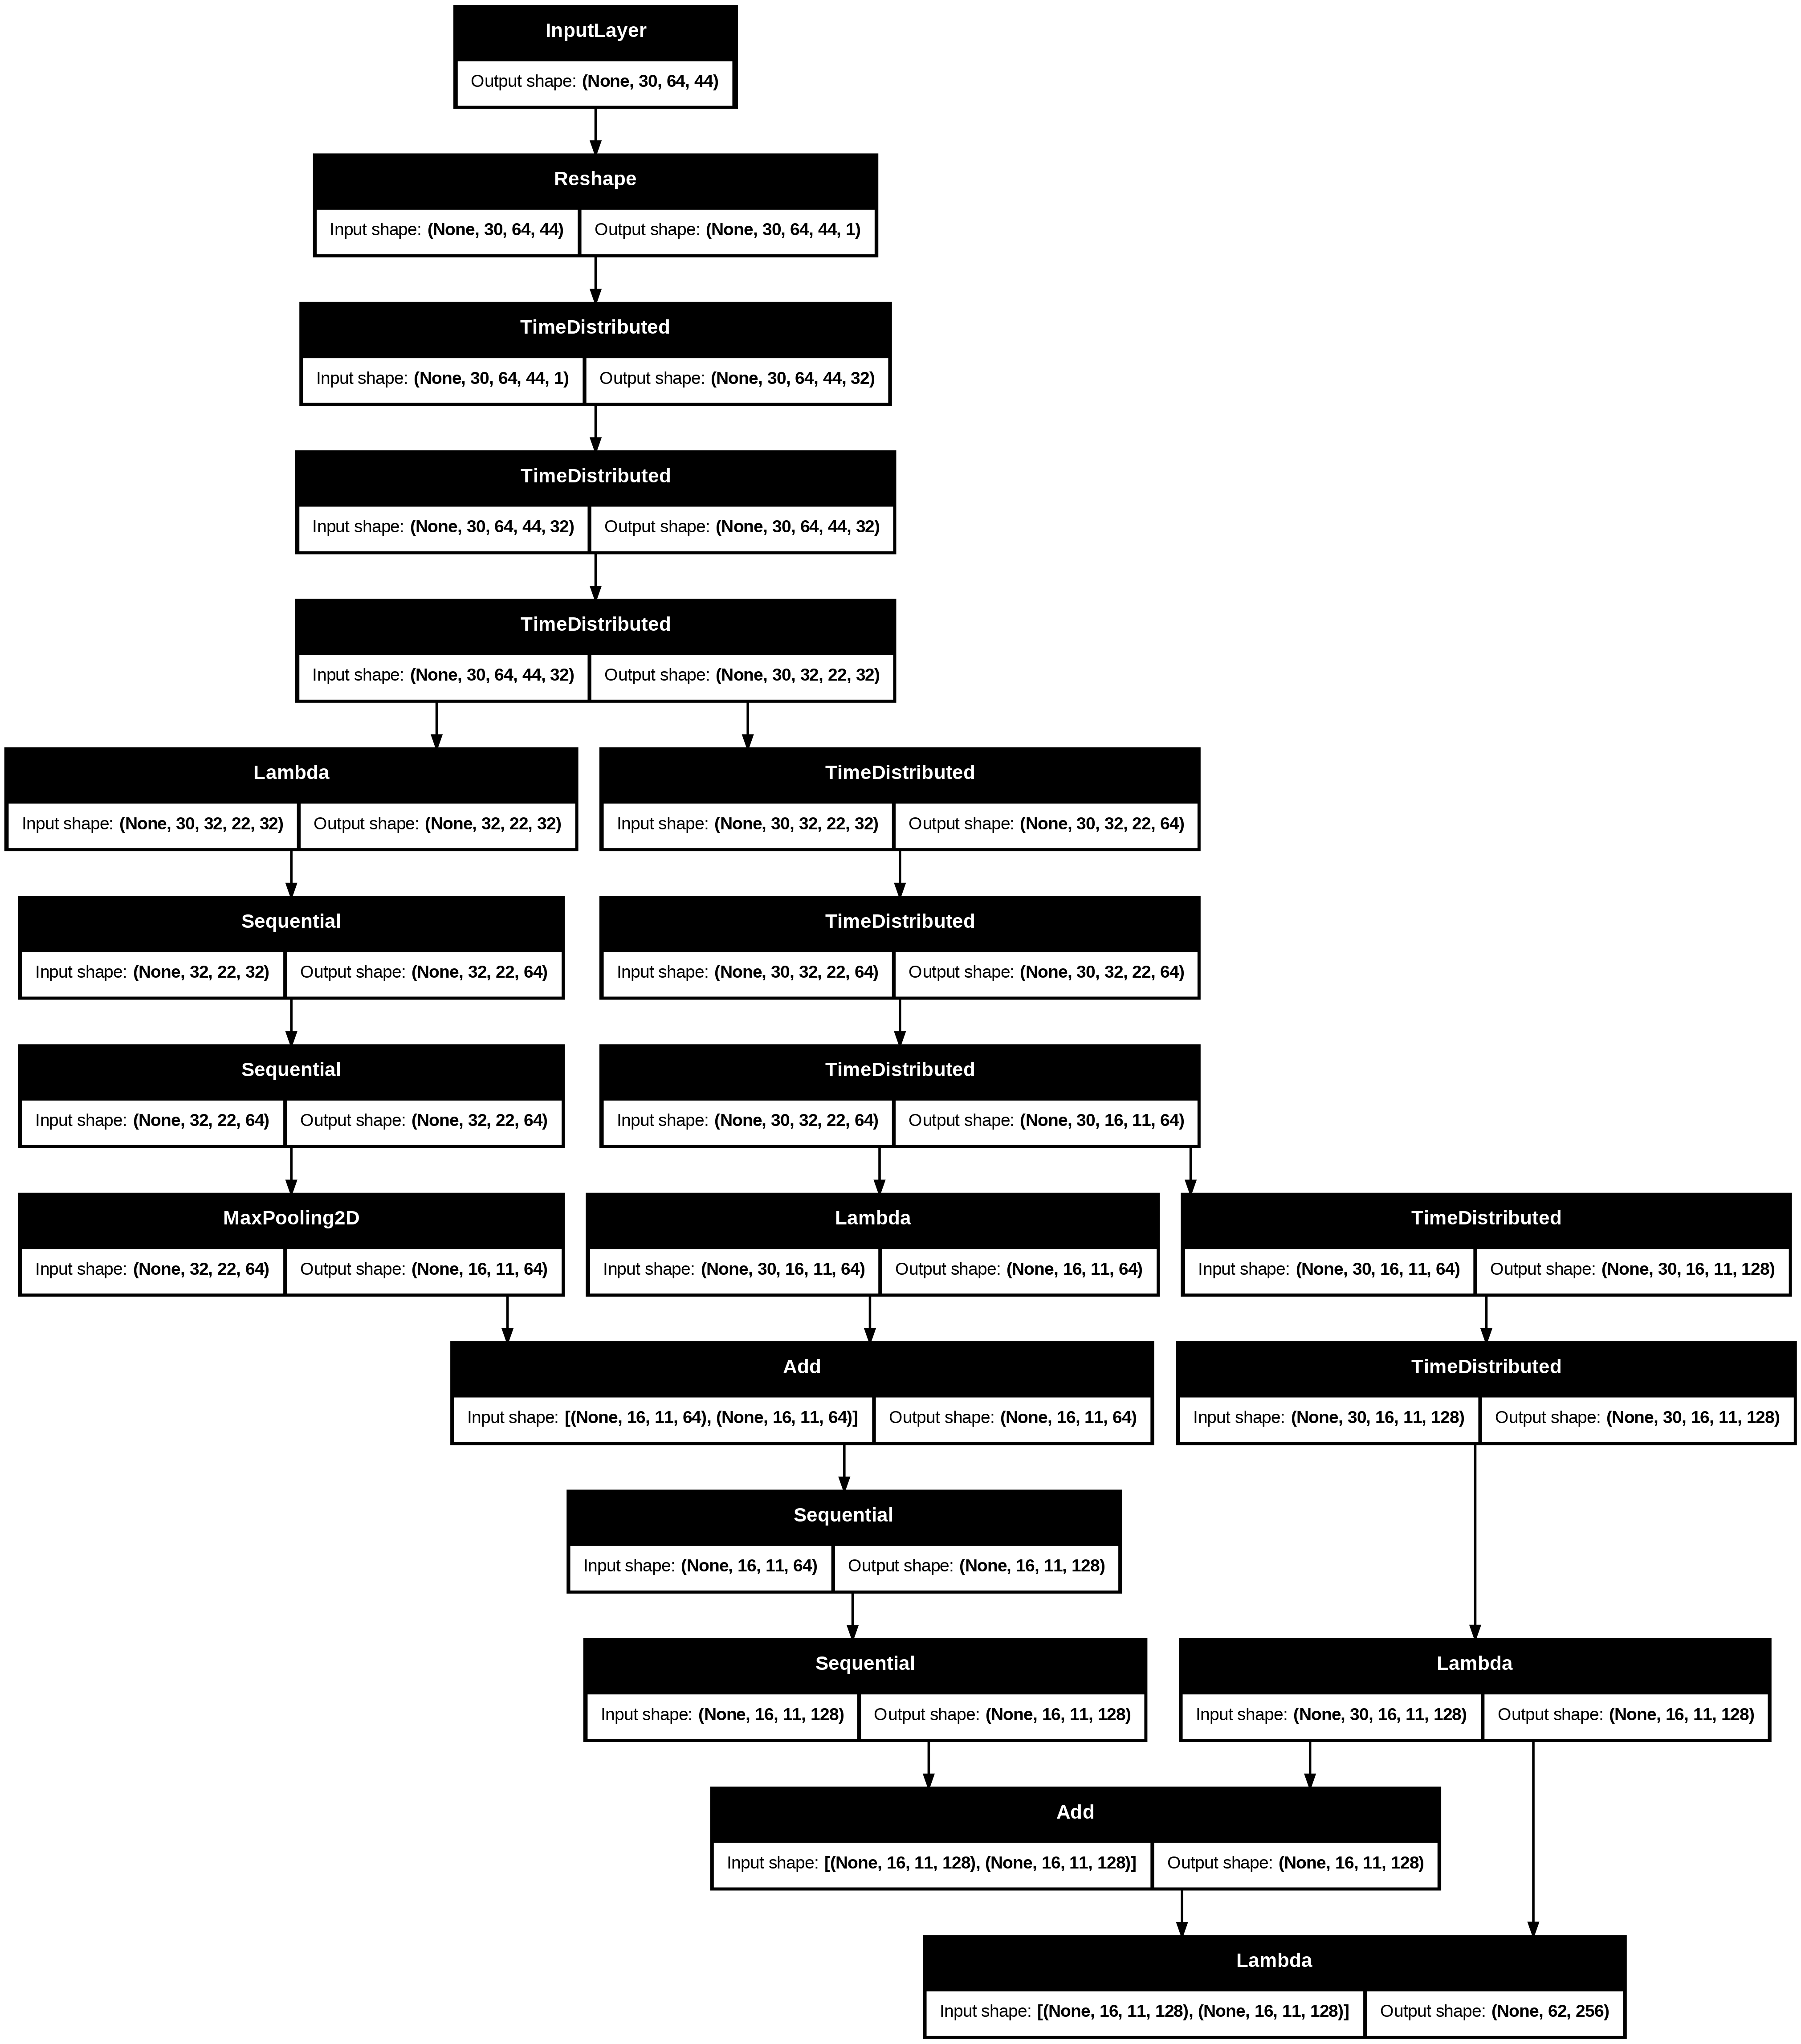

In [ ]:
plot_model(model, to_file="gaitset_plot.png", show_shapes=True)